# Predicting Malaria in Nigeria with Machine Learning - Approach 1: GeoSpatial Image Data

## Machine Learning Project for Abt Associates through the Univeristy of Michigan

### Contributors: Brian Liggio, Jessica Sickles, Prashant Toteja, Keely Meyers

The overarching goal for this project was to create a model that would predict malaria outbreaks in Nigeria.  The data for this project consists of various spatial images from open data sources (Malaria Atlas Project and Terraclip).  These images were manually cropped, scaled, and transformed in order to be compatible with the machine learning model.  The data analysis portion of the project included preliminary data cleaning, transforming image data to a Pandas dataframe, and creating a basic prediction visualization based on various machine learning techniques.  These steps produced initial image based on the collected spatial data. (add more as the model becomes more robust and interactive features are added to the map)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.image as mpimg
import numpy
from PIL import Image
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import learning_curve, GridSearchCV, train_test_split, KFold #new version of model_selection
#from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
#from sklearn.cross_validation import KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import statsmodels.formula.api as smf
import statsmodels.api as sm


#from gridsearch import get_results
import time
import itertools
from sklearn.linear_model import Ridge
%pylab inline

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


/Users/prashanttoteja/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


##### Here we define three different functions:

**feature_to_array**: The input of the function is a raster file with dimentions (n pixels,m pixels), and the output is going to be an array of dimmensions (m*n,1). *Each pixel is going to have a unique identifier (index in the array). This index follows the formula *(i*n)+j where (i,j) is the position of the pixel in the image and n is the width of the image.

**rgb2gray**: Converts an RGB image or colormap to grayscale.

**read_pictures**: Used to read in the images.

In [2]:
def feature_to_array(file_n): #Input is raster file with dimensions (n pixels, m pixels) and the output is an array of dimensions (m*n,1) -- Each pixel has a unique identifier
    im = mpimg.imread(file_n)  
    im_greyscale = rgb2gray(im)   
    imarray = numpy.array(im_greyscale)
    feature=[i for a in imarray for i in a]
    return feature

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])   #Greyscale value dimensions

def read_pictures(filename):   #Function to read the images in
    file_name=filename
    im = mpimg.imread(file_name)  
    im_greyscale = rgb2gray(im)

## Reading the Data

We insert each image into our feature_to_array function and assign each output to a variable respresenting the data within the respective image. We chose to use "endemicity" as our Y variable. In our regression model, we define endemicity as the predicted percentage of malaria prevalence in a given area.  We have chosen 12 predictor variables to include in our model.

##### Predcitor Variables:

resistance: Mean estimates of sickle cell haemoglobin allele frequency

fever_proportion: Malaria-positive fevers as a proportion of all-cause fevers in 2015 in Nigeria

mosquito_proportion: The spatial distribution of Plasmodium falciparum malaria endemicity in 2015 in Nigeria

temp_suitability: The annual temperature suitability index for Plasmodium falciparum transmission which reflects the impact of daily temperature on vector survival 

proximity_to_urban: Modeled accessibility to high-density urban centers for 2015 in Nigeria (measured by travel time)

urban: Modeled distribution of urban centers 

annual_mean_temp: Annual mean temperature 

cropland: Distribution of natural vegetation 

precipitation: Precipitation seasonality

vegetation: Areas of primary vegetation 

annual_temp_range: Annual temperature range

water_bodies: Locations of all water bodies 

In [3]:
file_name = 'Malaria_resistance_sickle_cell.png'
resistance = feature_to_array(file_name) 

file_name ='PfMalaria_fever_porportion_to_all_illness_2015.png'
fever_proportion = feature_to_array(file_name) 

file_name = 'PfPR_2015_NGA_proportion_2_10.png'
mosquito_proportion = feature_to_array(file_name) 

file_name = 'temp_suitability.png'
temp_suitability = feature_to_array(file_name) 

file_name = 'Travel_time_to_urban_centers.png'
proximity_to_urban = feature_to_array(file_name) 

file_name = 'Urban2012.png'
urban = feature_to_array(file_name) 

file_name = 'USE_annual_mean_temp.png'
annual_mean_temp = feature_to_array(file_name) 

file_name = 'USE_cropland.png'
cropland = feature_to_array(file_name)

file_name = 'USE_prec_seasonality_013.png'
precipitation = feature_to_array(file_name)

file_name = 'USE_primary_vegetation.png'
vegetation = feature_to_array(file_name)

file_name = 'USE_temp_annual_range_2015.png'
annual_temp_range = feature_to_array(file_name)

file_name = 'Water_bodies.png'
water_bodies = feature_to_array(file_name)

file_name = 'PF_parasite_endemicity.png'    #Y variable
endemicity = feature_to_array(file_name) 

file_name = 'Land_coverage.png'     #In or outside Nigeria
land_coverage = feature_to_array(file_name) 

In [4]:
data = pd.DataFrame([resistance, fever_proportion, mosquito_proportion, temp_suitability, proximity_to_urban, urban, annual_mean_temp, cropland, precipitation, vegetation, annual_temp_range, water_bodies, endemicity]).T

data.columns = ['Resistance','Fever_prop','Mosquito_prop', 'Temp_suitability','Proximity_to_urban','Urban','Annual_mean_temp','Cropland','Precipitation', 'Vegetation', 'Annual_temp_range', 'Water_bodies', 'Endemicity']


## Machine Learning - Regressions

In [5]:
## Splitting into X and Y training/testing sets

data = data.dropna()

X = data[['Resistance', 'Fever_prop','Mosquito_prop','Temp_suitability', 'Proximity_to_urban', 'Urban', 'Annual_mean_temp', 'Cropland', 'Precipitation','Vegetation', 'Annual_temp_range', 'Water_bodies']]
Y = data['Endemicity']

X_train, X_test = train_test_split(X, test_size=0.2, random_state=21)
Y_train, Y_test = train_test_split(Y, test_size=0.2, random_state=21)


## Ordinary Least Squares Regression

The purpose of this linear regression was use the predictor variables to identify areas of high or low malria risk. The model achieved an R-squared value of over 0.93, indicating that over 93% of the variability in the Y variable (endemicity) was explained by the model.  This indicated a significant and accurate model. The predictons were then mapped from an array back to an image to produce the static output seen below.

In [6]:
model = sm.OLS(Y, X, standardize=False).fit()   #fitting OLS to our data
print(model.summary())
data['Predictions_OLS_1'] = model.predict(X)    #using function to visualize model's fit

                            OLS Regression Results                            
Dep. Variable:             Endemicity   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                 1.489e+05
Date:                Fri, 19 Apr 2019   Prob (F-statistic):               0.00
Time:                        20:53:10   Log-Likelihood:                 61883.
No. Observations:              120432   AIC:                        -1.237e+05
Df Residuals:                  120421   BIC:                        -1.236e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Resistance             0.8268      0

In [7]:
## Creating training/testing data sets w/ both X & Y

data_train = pd.concat([X_train,Y_train],axis=1)
data_test = pd.concat([X_test,Y_test],axis=1)

In [8]:
## Evaluating Model

#ols_mod_train = smf.ols('Endemicity ~ Resistance + Fever_prop + Temp_suitability + Proximity_to_urban + Urban + Annual_mean_temp + Cropland + Precipitation + Mosquito_prop + Vegetation + Annual_temp_range + Water_bodies', data = data_train).fit()
#print (roc_auc_score(np.where(ols_mod_train.predict(data_test)>0.5,1,0), data_test['Endemicity']))


In [9]:
#print (roc_auc_score(np.where(ols_mod_train.predict(data)>0.5,1,0),data['Endemicity']))

In [10]:
data['Predictions_OLS_1'].head(10) #View of first 10 predictions as per the model

0    0.96583
1    0.96583
2    0.96583
3    0.96583
4    0.96583
5    0.96583
6    0.96583
7    0.96583
8    0.96583
9    0.96583
Name: Predictions_OLS_1, dtype: float64

In [11]:
## Linking array to original position of pixels 

file_name='USE_annual_mean_temp.png'
m=numpy.array(Image.open(file_name)).shape[0]
n=numpy.array(Image.open(file_name)).shape[1]
def indexes(m,n):    
    index_2dim={}
    for M in range(0,m*n):
        index_2dim[M]={'i':int(M)//int(n), 'j':M-((int(M)//int(n))*n)}
    return index_2dim
original_index_dict=indexes(m,n)


In [12]:
matrix = np.zeros((m,n))
for M in data.index:
    i=original_index_dict[M]['i']
    j=original_index_dict[M]['j']
    matrix[i][j]=data.Predictions_OLS_1[M] 
m_l=matrix.tolist()

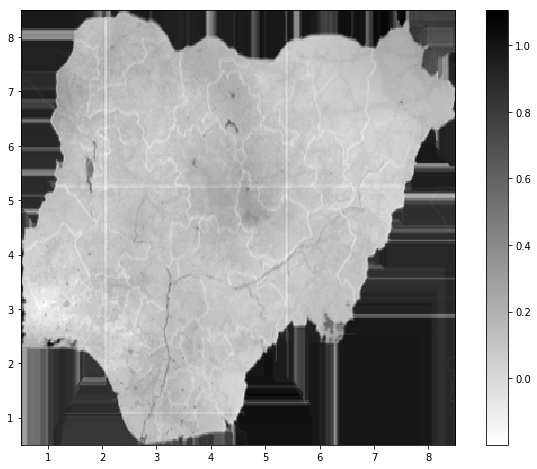

In [13]:
## Creating plot of malaria outbreak 

fig, ax = subplots(figsize=(11, 8))
plt.imshow(m_l,  interpolation='nearest', cmap='binary', extent=(0.5,8.5,0.5,8.5))
plt.colorbar()
plt.savefig('ols.png')

## Random Forest Regressor

The random forest model was implemented from sklearn and was ran with 1000 trees as an arbitrary start.  The model achieved a high fit score of 0.98.  The feature importance was gathered for each variable in the model and was used to create a datafram based on this metric.  This datafram was used to make predictions about areas of high and low risk for malaria in Nigeria, and display those prediction on another static map.

In [14]:
from sklearn.ensemble import RandomForestRegressor

In [15]:
rf = RandomForestRegressor(n_estimators = 10, random_state = 5) #changed to 10 and 5 to run faster(originally 1,000 estimators and random state 42)

In [16]:
rf.fit(X, Y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=5, verbose=0, warm_start=False)

In [17]:
rf.score(X,Y)

0.987307351477745

In [18]:
rf.feature_importances_

array([6.21485980e-02, 1.41115863e-02, 1.58998959e-02, 8.41682707e-01,
       1.88211899e-02, 1.59018298e-04, 5.80577379e-03, 3.31595803e-03,
       1.62245086e-02, 5.95443520e-04, 2.10495884e-02, 1.85732760e-04])

In [19]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = X.columns, columns=['importance']).sort_values('importance', ascending=False)
feature_importances


,importance
Temp_suitability,0.841683
Resistance,0.062149
Annual_temp_range,0.021050
Proximity_to_urban,0.018821
Precipitation,0.016225
Mosquito_prop,0.015900
Fever_prop,0.014112
Annual_mean_temp,0.005806
Cropland,0.003316
Vegetation,0.000595


In [20]:
data['rf_predictions'] = rf.predict(X)

In [21]:
data['rf_predictions'].head(10)

0    0.999998
1    0.999998
2    0.999998
3    0.999998
4    0.999998
5    0.999998
6    0.999998
7    0.999998
8    0.999998
9    0.999998
Name: rf_predictions, dtype: float64

In [22]:
errors = abs(data['rf_predictions'] - Y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 0.01


In [23]:
## Calculating mean absolute percentage error (MAPE)

mape = 100 * (errors / Y_test)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), "%")

Accuracy: 94.61 %


In [24]:
## Linking array to original position of pixels 

file_name='USE_annual_mean_temp.png'
m=numpy.array(Image.open(file_name)).shape[0]
n=numpy.array(Image.open(file_name)).shape[1]
def indexes(m,n):    
    index_2dim={}
    for M in range(0,m*n):
        #print(M)
        index_2dim[M]={'i':int(M)//int(n), 'j':M-((int(M)//int(n))*n)}
    return index_2dim
original_index_dict=indexes(m,n)

In [25]:
matrix = np.zeros((m,n))
for M in data.index:
    i=original_index_dict[M]['i']
    j=original_index_dict[M]['j']
    matrix[i][j]= data.rf_predictions[M] 
m_l=matrix.tolist()

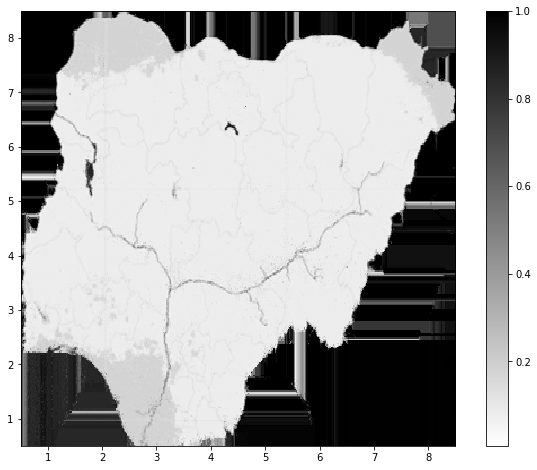

In [26]:
## Creating plot of malaria outbreak 

fig, ax = subplots(figsize=(11, 8))
plt.imshow(m_l,  interpolation='nearest', cmap='binary', extent=(0.5,8.5,0.5,8.5))
plt.colorbar()
plt.savefig('rf.png')

## TensorFlow Keras Neural Network

Here, we are using a neural network from the keras package supported by TensorFlow. In reality, the relationship between our inputs and malaria outbreaks is probably non-linear and complex. Thus, this model is advantageous as it has the ability to learn these types of relationships. They are typically used in pattern recognition which is applicable here since we are interesting in using the surrounding neighborhoods to predict endemicity just how epidemics work in real life.

In [27]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, Activation,Conv2D,MaxPooling2D,Flatten,Dropout

Using TensorFlow backend.


In [28]:
X = data[['Resistance', 'Fever_prop','Mosquito_prop','Temp_suitability', 'Proximity_to_urban', 'Urban', 'Annual_mean_temp', 'Cropland', 'Precipitation','Vegetation', 'Annual_temp_range', 'Water_bodies']]
Y = data['Endemicity']

X_train, X_test = train_test_split(X, test_size=0.2, random_state=21)  #splitting train and test
Y_train, Y_test = train_test_split(Y, test_size=0.2, random_state=21)


In [29]:
model = Sequential() #implementation of a sequential model for testing purposes
model.add(Dense(input_dim=12, output_dim=1, init='uniform', activation='linear'))  #adding one fully connected layer with linear activation


Instructions for updating:
Colocations handled automatically by placer.


In [30]:
digit_input = Input(shape=(28, 28,1)) 
x = Conv2D(64, (3, 3))(digit_input) #creating convolutional layers with 64 filters size 3x3
x = Conv2D(64, (3, 3))(x)
#x = MaxPooling2D((2, 2))(x)
#out = Flatten()(x)

In [31]:
#Assigning weights to the model

weights = model.layers[0].get_weights()
w_init = weights[0][0][0]
b_init = weights[1][0]
print('Model is initialized with weights w: %.2f, b: %.2f' % (w_init, b_init)) 

Model is initialized with weights w: -0.04, b: 0.00


In [32]:
model.compile(optimizer='sgd', loss='mse')

In [33]:
model.fit(X_train, Y_train, nb_epoch=10, verbose=1)  #fitting model

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
96345/96345 [==============================] - 6s 57us/step - loss: 0.0332
Epoch 2/10
96345/96345 [==============================] - 5s 47us/step - loss: 0.0233
Epoch 3/10
96345/96345 [==============================] - 5s 50us/step - loss: 0.0228
Epoch 4/10
96345/96345 [==============================] - 4s 46us/step - loss: 0.0225
Epoch 5/10
96345/96345 [==============================] - 5s 47us/step - loss: 0.0222
Epoch 6/10
96345/96345 [==============================] - 5s 47us/step - loss: 0.0220
Epoch 7/10
96345/96345 [==============================] - 5s 47us/step - loss: 0.0219
Epoch 8/10
96345/96345 [==============================] - 5s 51us/step - loss: 0.0218
Epoch 9/10
96345/96345 [==============================] - 5s 48us/step - loss: 0.0216
Epoch 10/10
96345/96345 [==============================] - 5s 50us/step - loss: 0.0216


In [34]:
ynew = model.predict(X_test)  #prediction on our test set

In [35]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(Y_test, ynew)  #calculating error between predicitons and actual

0.08689161330034946

# Malaria Treated as a Classification Problem

## Logistic Regression

Another approach that was used was to treat the prediction of malaria risk as a classification problem, in which an "at risk" area is defined as one with a risk greater than 0.5, and a "non-risk" areas is one with a risk less than 0.5.  This model produced an Area Under the Curve AUC score of 0.98, a high score. A perfect model will have an AUC score of 1 while a completely ineffective model will score 0.5.

In [36]:
#logit_mod = smf.logit('Endemicity ~ Resistance + Fever_prop + Mosquito_prop + Temp_suitability + Proximity_to_urban + Urban + Annual_mean_temp + Cropland + Precipitation + Vegetation + Annual_temp_range + Water_bodies', data = data).fit()
#print ('\n',logit_mod.summary())

In [37]:
#print (logit_mod.get_margeff().summary())

In [38]:
## Prediction

#data['PredictionLogit'] = logit_mod.predict(data)
#data.loc[data['PredictionLogit'] >= .5, 'PredictionLogit'] = 1
#data.loc[data['PredictionLogit'] < .5, 'PredictionLogit'] = 0
# print(sorted(data['PredictionLogit']))

In [39]:
## Creating training/testing data sets w/ both X & Y

#data_train = pd.concat([X_train,Y_train],axis=1)
#data_test = pd.concat([X_test,Y_test],axis=1)

In [40]:
## Evaluating Model 

#logit_mod_train = smf.logit('Endemicity ~ Resistance + Fever_prop + Temp_suitability + Proximity_to_urban + Urban + Annual_mean_temp + Cropland + Precipitation + Mosquito_prop + Vegetation + Annual_temp_range + Water_bodies', data = data_train).fit()
#print (roc_auc_score(np.where(logit_mod_train.predict(data_test)>0.5,1,0), data_test['Endemicity']))

In [41]:
#print (roc_auc_score(np.where(logit_mod_train.predict(data)>0.5,1,0),data['Endemicity']))

In [42]:
## Linking array to original position of pixels 

#file_name='USE_annual_mean_temp.png'
#m=numpy.array(Image.open(file_name)).shape[0]
#n=numpy.array(Image.open(file_name)).shape[1]
#def indexes(m,n):    
 #   index_2dim={}
  #  for M in range(0,m*n):
   #     index_2dim[M]={'i':int(M)//int(n), 'j':M-((int(M)//int(n))*n)}
    #return index_2dim
#original_index_dict=indexes(m,n)

In [43]:
## Creating labels to plot 

#matrix = np.zeros((m,n))
#for M in data.index:
    #i=original_index_dict[M]['i']
    #j=original_index_dict[M]['j']
    #matrix[i][j]=data.PredictionLogit[M] 
#m_l=matrix.tolist()



In [44]:
## Creating plot of malaria outbreak 

'''fig, ax = subplots(figsize=(10, 8))
plt.imshow(m_l, interpolation='nearest', cmap='Blues', extent=(0.5,10.5,0.5,10.5))
plt.colorbar()
plt.savefig('logit.png')'''

"fig, ax = subplots(figsize=(10, 8))\nplt.imshow(m_l, interpolation='nearest', cmap='Blues', extent=(0.5,10.5,0.5,10.5))\nplt.colorbar()\nplt.savefig('logit.png')"

## Conditional Random Fields - A Discrimitive Approach

The GraphCRF is another model that can be useful in predicting malaria endemicity. It utilizes the surrounding areas or "neighboring nodes" (pairwise models) as factors or weights of consideration, which mimics the reality of disease epidemics. While neural networks might work well with larger amounts of data, we can expect the CRF to do a better job with generalizations. This approach was still under construction at the time of hand-off. We have been exploring the structure of our input data and have been working to format it correctly for the model fitting. 

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt

import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
#from sklearn.cross_validation import cross_val_score
#from sklearn.grid_search import RandomizedSearchCV
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

In [46]:
X.head(10)

,Resistance,Fever_prop,Mosquito_prop,Temp_suitability,Proximity_to_urban,Urban,Annual_mean_temp,Cropland,Precipitation,Vegetation,Annual_temp_range,Water_bodies
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.023529,0.533333,0.003922,0.937255,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.023529,0.533333,0.003922,0.937255,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.023529,0.533333,0.003922,0.937255,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.023529,0.533333,0.003922,0.937255,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.023529,0.533333,0.003922,0.937255,1.0
5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.023529,0.533333,0.003922,0.937255,1.0
6,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.023529,0.533333,0.003922,0.937255,1.0
7,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.023529,0.533333,0.003922,0.937255,1.0
8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.023529,0.533333,0.003922,0.937255,1.0
9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.023529,0.533333,0.003922,0.937255,1.0


In [47]:
X.shape

(120432, 12)

In [48]:
n_nodes = X.shape[1]
n_nodes

12

In [49]:
edges_0 = np.vstack([np.arange(n_nodes - 1), np.arange(1, n_nodes)])
edges_0

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]])

In [50]:
x = (np.asarray(X.iloc[:,0]), edges_0)   ##list of a list for first requires - exploring our the structure of our data
x

(array([1., 1., 1., ..., 1., 1., 1.]),
 array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]))

In [51]:
f_t = X

In [52]:
#Constructing tuple of nodes for features and edges between the nodes

crf_xtrain = []
cols = []
for i in range(0, f_t.shape[1]):
    for j in range(0, f_t.shape[1]):  #iterating by columns in dataframe
        x = np.asarray(f_t.iloc[:,j])
        cols.append(x)
        if (len(cols) == 12):
            crf_xtrain.append(((np.asarray(cols)),edges_0))  
            cols = []

In [53]:
len(crf_xtrain[0][0][0])  #make table with 1 row instead of a list 
crf_xtrain[0][0][0]

array([1., 1., 1., ..., 1., 1., 1.])

In [54]:
crf_ytrain = Y
type(crf_ytrain[0])

numpy.float64

In [55]:
for idx in range(len(crf_ytrain)):   #forcing values to ones and zeros
    if (crf_ytrain[idx] >= .5):  
        crf_ytrain[idx] = 1
    else:
        crf_ytrain[idx] = 0


In [56]:
crf_ytrain = crf_ytrain.astype(int)
u = list(set(crf_ytrain))
u

[0, 1]

In [57]:
crf_ytrain = np.asarray(crf_ytrain)
crf_ytrain

array([1, 1, 1, ..., 1, 1, 1])

In [58]:
from pystruct.models import GraphCRF
from pystruct.learners import FrankWolfeSSVM

In [60]:
model = GraphCRF(directed = True, inference_method = "max-product")
ssvm = FrankWolfeSSVM(model=model, C=.1, max_iter=10)
#ssvm.fit(crf_xtrain, crf_ytrain)    #fitting model to our training data 

## Approach One Conclusion:

After attempting a few different models, it appears that OLS works the best given its high fit and accurate output. However, we would recommend building upon the CRF further to see the interactivity between nodes. Given that the geospatial image data that we used was not accurately linked to geocoordinates, we will see if we can use survey data from the MAP Atlas Project and API data in Approach Two to replicate these results and better link them to specific locations within Nigeria.